# Text2Time Module Tutorial
This notebook demonstrates the use of pvops to analyze a combination of operations and maintenance (OM) and production data. The data will be processed and cleaned in preparation for an intersection analysis and subsequent visualizations.

Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import sys
import os

In [2]:
from pvops.text2time import visualize, utils, preprocess
from pvops.timeseries.models import linear, iec

## 1. Load and explore data


Define csv paths to OM, production, and meta data.

In [3]:
example_OMpath = os.path.join('example_data', 'example_om_data2.csv')
example_prodpath = os.path.join('example_data', 'example_prod_data_cumE2.csv')
example_metapath = os.path.join('example_data', 'example_metadata2.csv')

Load in csv files as pandas DataFrames. `prod_data` contains energy production and irradiance data over time for potentially multiple sites. `om_data` contains operations and maintenance tickets. `metadata` contains information about the sites, such as location and DC size.

In [4]:
prod_data = pd.read_csv(example_prodpath, on_bad_lines='skip', engine='python')
om_data = pd.read_csv(example_OMpath, on_bad_lines='skip', engine='python')
metadata = pd.read_csv(example_metapath, on_bad_lines='skip', engine='python')

Explore production data

In [5]:
prod_data

,randid,Date,Energy,Irradiance
0,R23,NaN,1000.0,NaN
1,R23,7/19/2018 1:00,1000.0,NaN
2,R23,7/19/2018 2:00,0.0,NaN
3,R23,7/19/2018 3:00,0.0,NaN
4,R23,7/19/2018 4:00,1000.0,NaN
...,...,...,...,...
1049,R27,10/13/2018 23:45,5289528.0,NaN
1050,R27,10/14/2018 0:00,5289528.0,NaN
1051,R27,10/14/2018 0:15,5289528.0,NaN
1052,R27,10/14/2018 0:30,5289528.0,NaN


Explore OM data

In [6]:
om_data

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
0,NaN,Inverter,5/2/2018 12:00,5/17/2018 16:00,100,Corrective,"Inverter 1.1 Contactor 7, Inverter 1.2 Contact..."
1,R23,Facility,5/19/2018 15:44,5/19/2018 13:04,101,Preventive,Site offline due to grid disturbance
2,R23,Facility,6/15/2018 6:46,6/15/2018 10:30,102,Corrective,Plant trip due to grid disturbance
3,R23,Facility,6/18/2018 11:20,6/18/2018 14:03,103,Corrective,Site trip due to cause grid disturbance
4,R23,Facility,7/21/2018 4:45,7/21/2018 13:15,104,Vegetation,Site tripped due to grid disturbance
5,R23,Inverter,7/21/2018 13:16,7/21/2018 14:25,105,Corrective,Inverter failed to start following plant trip
6,R23,Inverter,7/25/2018 14:20,7/25/2018 16:40,106,Corrective,inverter offline due to high ambient temp fault
7,R23,Inverter,8/1/2018 11:45,NaN,107,Corrective,Inverter major underperformance
8,R23,Facility,8/2/2018 1:05,8/2/2018 9:28,108,Corrective,Site trip due to grid disturbance
9,R27,Facility,9/14/2018 10:00,9/16/2018 16:00,1,corrective,hurricane florence outages/response. complete ...


Explore metadata

In [7]:
metadata

,randid,DC_Size_kW,COD,latitude,longitude
0,R23,2500,10/20/2013,-80,-35
1,R27,475,10/21/2017,-81,-36


## 2. Prepare data for analysis

Assigning dictionaries to connect pvOps variables with user's column names.

In [8]:
#Format for dictionaries is {pvops variable: user-specific column names}
prod_col_dict = {'siteid': 'randid', 
                 'timestamp': 'Date', 
                 'energyprod': 'Energy',
                 'irradiance':'Irradiance',
                 'baseline': 'IEC_pstep', #user's name choice for new column (baseline expected energy defined by user or calculated based on IEC)
                 'dcsize': 'dcsize', #user's name choice for new column (System DC-size, extracted from meta-data)
                 'compared': 'Compared',#user's name choice for new column
                 'energy_pstep': 'Energy_pstep'} #user's name choice for new column

om_col_dict = {'siteid': 'randid', 
               'datestart': 'date_start',
               'dateend': 'date_end',
               'workID': 'WONumber',
               'worktype': 'WOType',
               'asset': 'Asset',
               'eventdur': 'EventDur', #user's name choice for new column (Repair Duration)
               'modatestart': 'MonthStart', #user's name choice for new column (Month when an event begins)
               'agedatestart': 'AgeStart'} #user's name choice for new column (Age of system when event begins)

metad_col_dict = {'siteid': 'randid',
                  'dcsize': 'DC_Size_kW',
                  'COD': 'COD'}

### 2.1 Convert date strings to date-time objects

#### O&M Data

In [9]:
#Note:  NaNs are converted to NaTs
om_data_converted = preprocess.om_date_convert(om_data, om_col_dict)

print('---Original data types---')
print(om_data.dtypes)
print('\n---Post-processed data types---')
print(om_data_converted.dtypes)
print('\n---Converted data frame---')
om_data_converted.head()

---Original data types---
randid         object
Asset          object
date_start     object
date_end       object
WONumber        int64
WOType         object
GeneralDesc    object
dtype: object

---Post-processed data types---
randid                 object
Asset                  object
date_start     datetime64[ns]
date_end       datetime64[ns]
WONumber                int64
WOType                 object
GeneralDesc            object
dtype: object

---Converted data frame---


,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
0,NaN,Inverter,2018-05-02 12:00:00,2018-05-17 16:00:00,100,Corrective,"Inverter 1.1 Contactor 7, Inverter 1.2 Contact..."
1,R23,Facility,2018-05-19 15:44:00,2018-05-19 13:04:00,101,Preventive,Site offline due to grid disturbance
2,R23,Facility,2018-06-15 06:46:00,2018-06-15 10:30:00,102,Corrective,Plant trip due to grid disturbance
3,R23,Facility,2018-06-18 11:20:00,2018-06-18 14:03:00,103,Corrective,Site trip due to cause grid disturbance
4,R23,Facility,2018-07-21 04:45:00,2018-07-21 13:15:00,104,Vegetation,Site tripped due to grid disturbance


#### Production data

In [10]:
prod_data_converted = preprocess.prod_date_convert(prod_data, prod_col_dict)

print('---Original data types---')
print(prod_data.dtypes)
print('\n---Post-processed data types---')
print(prod_data_converted.dtypes)
print('\n---Converted data frame---')
prod_data_converted.head()

---Original data types---
randid         object
Date           object
Energy        float64
Irradiance    float64
dtype: object

---Post-processed data types---
randid                object
Date          datetime64[ns]
Energy               float64
Irradiance           float64
dtype: object

---Converted data frame---


,randid,Date,Energy,Irradiance
0,R23,NaT,1000.0,NaN
1,R23,2018-07-19 01:00:00,1000.0,NaN
2,R23,2018-07-19 02:00:00,0.0,NaN
3,R23,2018-07-19 03:00:00,0.0,NaN
4,R23,2018-07-19 04:00:00,1000.0,NaN


## 3. Handling data quality issues

### 3.1 Missing site-IDs

Drop rows where site-ID is NAN in OM-data (helpful when multiple sites are in O&M data frame and a NAN doesn't identify a specific site)

In [11]:
om_data_sitena, addressed = preprocess.data_site_na(om_data_converted, om_col_dict)
addressed #printing row that was addressed

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
0,NaN,Inverter,2018-05-02 12:00:00,2018-05-17 16:00:00,100,Corrective,"Inverter 1.1 Contactor 7, Inverter 1.2 Contact..."


Print post-processed data frame

In [12]:
om_data_sitena.head()

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
1,R23,Facility,2018-05-19 15:44:00,2018-05-19 13:04:00,101,Preventive,Site offline due to grid disturbance
2,R23,Facility,2018-06-15 06:46:00,2018-06-15 10:30:00,102,Corrective,Plant trip due to grid disturbance
3,R23,Facility,2018-06-18 11:20:00,2018-06-18 14:03:00,103,Corrective,Site trip due to cause grid disturbance
4,R23,Facility,2018-07-21 04:45:00,2018-07-21 13:15:00,104,Vegetation,Site tripped due to grid disturbance
5,R23,Inverter,2018-07-21 13:16:00,2018-07-21 14:25:00,105,Corrective,Inverter failed to start following plant trip


### 3.2 O&M Start-dates that occur after concluding date (inverted dates)

Addressing issue by swapping dates

In [13]:
om_data_checked_s, addressed = preprocess.om_datelogic_check(om_data_sitena, om_col_dict, 'swap')
addressed

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
1,R23,Facility,2018-05-19 15:44:00,2018-05-19 13:04:00,101,Preventive,Site offline due to grid disturbance
10,R27,Facility,2018-09-24 10:00:00,2018-09-16 17:00:00,2,vegetation,Vegetation maintenance activities were performed


Print post-processed data frame


In [14]:
om_data_checked_s.head()

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
1,R23,Facility,2018-05-19 13:04:00,2018-05-19 15:44:00,101,Preventive,Site offline due to grid disturbance
2,R23,Facility,2018-06-15 06:46:00,2018-06-15 10:30:00,102,Corrective,Plant trip due to grid disturbance
3,R23,Facility,2018-06-18 11:20:00,2018-06-18 14:03:00,103,Corrective,Site trip due to cause grid disturbance
4,R23,Facility,2018-07-21 04:45:00,2018-07-21 13:15:00,104,Vegetation,Site tripped due to grid disturbance
5,R23,Inverter,2018-07-21 13:16:00,2018-07-21 14:25:00,105,Corrective,Inverter failed to start following plant trip


Addressing issue by dropping rows instead of swapping dates

In [15]:
om_data_checked_d, date_error = preprocess.om_datelogic_check(om_data_sitena, om_col_dict, 'drop')
om_data_checked_d.head()

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
2,R23,Facility,2018-06-15 06:46:00,2018-06-15 10:30:00,102,Corrective,Plant trip due to grid disturbance
3,R23,Facility,2018-06-18 11:20:00,2018-06-18 14:03:00,103,Corrective,Site trip due to cause grid disturbance
4,R23,Facility,2018-07-21 04:45:00,2018-07-21 13:15:00,104,Vegetation,Site tripped due to grid disturbance
5,R23,Inverter,2018-07-21 13:16:00,2018-07-21 14:25:00,105,Corrective,Inverter failed to start following plant trip
6,R23,Inverter,2018-07-25 14:20:00,2018-07-25 16:40:00,106,Corrective,inverter offline due to high ambient temp fault


### 3.3 Unexpected drops in energy delivered (when collected on cumulative basis)

Visualize pre-processed data

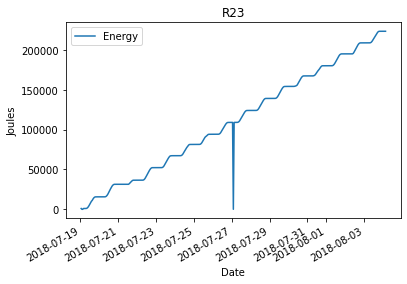

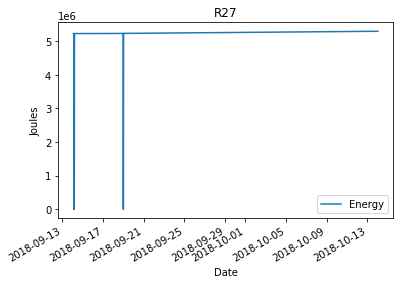

In [16]:
plotvar = 'Energy'
for sid in prod_data_converted.loc[:, 'randid'].unique():
    mask = prod_data_converted.loc[:, 'randid']== sid
    prod_data_converted.loc[mask].plot(x='Date',y=plotvar, title=sid)
    plt.ylabel('Joules')

Addressing issue by forward-filling, which propagates last valid observation forward.

In [17]:
prod_data_anom, addressed = utils.prod_anomalies(prod_data_converted, prod_col_dict, 1.0, np.nan, ffill=True)
addressed

,randid,Date,Energy,Irradiance
2,R23,2018-07-19 02:00:00,0.0,NaN
3,R23,2018-07-19 03:00:00,0.0,NaN
194,R23,2018-07-27 02:00:00,0.0,NaN
395,R27,2018-09-14 04:00:00,0.0,0.616897
397,R27,2018-09-14 04:30:00,0.0,0.306548
860,R27,2018-09-19 00:15:00,0.0,0.000000


Print post-processed data frame


In [18]:
prod_data_anom

,randid,Date,Energy,Irradiance
0,R23,NaT,1000.0,NaN
1,R23,2018-07-19 01:00:00,1000.0,NaN
2,R23,2018-07-19 02:00:00,1000.0,NaN
3,R23,2018-07-19 03:00:00,1000.0,NaN
4,R23,2018-07-19 04:00:00,1000.0,NaN
...,...,...,...,...
1049,R27,2018-10-13 23:45:00,5289528.0,NaN
1050,R27,2018-10-14 00:00:00,5289528.0,NaN
1051,R27,2018-10-14 00:15:00,5289528.0,NaN
1052,R27,2018-10-14 00:30:00,5289528.0,NaN


Quick visualization of post-processed data

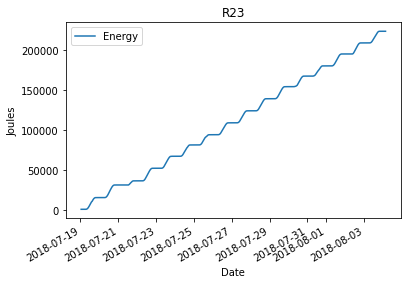

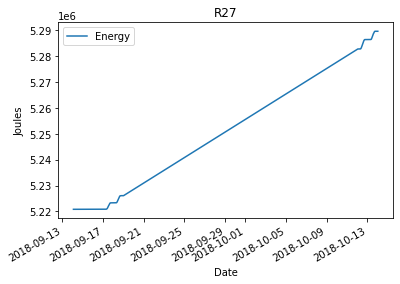

In [19]:
plotvar = 'Energy'
for sid in prod_data_anom.loc[:, 'randid'].unique():
    mask = prod_data_anom.loc[:, 'randid']== sid
    prod_data_anom.loc[mask].plot(x='Date',y=plotvar, title=sid)
    plt.ylabel('Joules')

### 3.4 Missing time-stamps in data

#### Production Data

Dropping rows with missing time-stamps

In [20]:
prod_data_datena_d, addressed = preprocess.prod_nadate_process(prod_data_anom, prod_col_dict, pnadrop=True)
addressed

,randid,Date,Energy,Irradiance
0,R23,NaT,1000.0,NaN
388,R27,NaT,5220831.0,0.095835


Print post-processed data frame


In [21]:
prod_data_datena_d

,randid,Date,Energy,Irradiance
1,R23,2018-07-19 01:00:00,1000.0,NaN
2,R23,2018-07-19 02:00:00,1000.0,NaN
3,R23,2018-07-19 03:00:00,1000.0,NaN
4,R23,2018-07-19 04:00:00,1000.0,NaN
5,R23,2018-07-19 05:00:00,1000.0,NaN
...,...,...,...,...
1049,R27,2018-10-13 23:45:00,5289528.0,NaN
1050,R27,2018-10-14 00:00:00,5289528.0,NaN
1051,R27,2018-10-14 00:15:00,5289528.0,NaN
1052,R27,2018-10-14 00:30:00,5289528.0,NaN


Identifying rows with missing time-stamps but not dropping them


In [22]:
prod_data_datena_id, addressed = preprocess.prod_nadate_process(prod_data_anom, prod_col_dict, pnadrop=False)
prod_data_datena_id

,randid,Date,Energy,Irradiance
0,R23,NaT,1000.0,NaN
1,R23,2018-07-19 01:00:00,1000.0,NaN
2,R23,2018-07-19 02:00:00,1000.0,NaN
3,R23,2018-07-19 03:00:00,1000.0,NaN
4,R23,2018-07-19 04:00:00,1000.0,NaN
...,...,...,...,...
1049,R27,2018-10-13 23:45:00,5289528.0,NaN
1050,R27,2018-10-14 00:00:00,5289528.0,NaN
1051,R27,2018-10-14 00:15:00,5289528.0,NaN
1052,R27,2018-10-14 00:30:00,5289528.0,NaN


#### O&M Data

Dropping rows when end-date of an event is missing

In [23]:
om_data_datena_d, addressed = preprocess.om_nadate_process(om_data_checked_s, om_col_dict, om_dendflag='drop')
addressed

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
7,R23,Inverter,2018-08-01 11:45:00,NaT,107,Corrective,Inverter major underperformance
13,R27,other,2018-10-14 11:00:00,NaT,5,preventive,Monthly visual inspection


Print post-processed data frame


In [24]:
om_data_datena_d

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
1,R23,Facility,2018-05-19 13:04:00,2018-05-19 15:44:00,101,Preventive,Site offline due to grid disturbance
2,R23,Facility,2018-06-15 06:46:00,2018-06-15 10:30:00,102,Corrective,Plant trip due to grid disturbance
3,R23,Facility,2018-06-18 11:20:00,2018-06-18 14:03:00,103,Corrective,Site trip due to cause grid disturbance
4,R23,Facility,2018-07-21 04:45:00,2018-07-21 13:15:00,104,Vegetation,Site tripped due to grid disturbance
5,R23,Inverter,2018-07-21 13:16:00,2018-07-21 14:25:00,105,Corrective,Inverter failed to start following plant trip
6,R23,Inverter,2018-07-25 14:20:00,2018-07-25 16:40:00,106,Corrective,inverter offline due to high ambient temp fault
8,R23,Facility,2018-08-02 01:05:00,2018-08-02 09:28:00,108,Corrective,Site trip due to grid disturbance
9,R27,Facility,2018-09-14 10:00:00,2018-09-16 16:00:00,1,corrective,hurricane florence outages/response. complete ...
10,R27,Facility,2018-05-19 13:04:00,2018-05-19 15:44:00,2,vegetation,Vegetation maintenance activities were performed
11,R27,Other,2018-09-19 07:00:00,2018-10-11 20:00:00,3,corrective,hurricane response. perform site inspection to...


Rather than dropping rows, assigning "today's" time-stamp for missing end-dates to consider an open ticket

In [25]:
om_data_datena_t, addressed = preprocess.om_nadate_process(om_data_checked_s, om_col_dict, om_dendflag='today')
om_data_datena_t

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
1,R23,Facility,2018-05-19 13:04:00,2018-05-19 15:44:00,101,Preventive,Site offline due to grid disturbance
2,R23,Facility,2018-06-15 06:46:00,2018-06-15 10:30:00,102,Corrective,Plant trip due to grid disturbance
3,R23,Facility,2018-06-18 11:20:00,2018-06-18 14:03:00,103,Corrective,Site trip due to cause grid disturbance
4,R23,Facility,2018-07-21 04:45:00,2018-07-21 13:15:00,104,Vegetation,Site tripped due to grid disturbance
5,R23,Inverter,2018-07-21 13:16:00,2018-07-21 14:25:00,105,Corrective,Inverter failed to start following plant trip
6,R23,Inverter,2018-07-25 14:20:00,2018-07-25 16:40:00,106,Corrective,inverter offline due to high ambient temp fault
7,R23,Inverter,2018-08-01 11:45:00,2023-01-12 12:26:26,107,Corrective,Inverter major underperformance
8,R23,Facility,2018-08-02 01:05:00,2018-08-02 09:28:00,108,Corrective,Site trip due to grid disturbance
9,R27,Facility,2018-09-14 10:00:00,2018-09-16 16:00:00,1,corrective,hurricane florence outages/response. complete ...
10,R27,Facility,2018-05-19 13:04:00,2018-05-19 15:44:00,2,vegetation,Vegetation maintenance activities were performed


## 4. Pre-visualizing preparation

### 4.1 Print out overview of the overlap of OM and production data

`prod_summary` indicates how many time stamps overlapped with OM data versus the total number of time stamps, broken down by site. `om_data` indicates the lower and upper time bounds on OM data and the number of events, broken down by site.

In [26]:
prod_summary, om_summary = utils.summarize_overlaps(prod_data_datena_d, om_data_datena_t, prod_col_dict, om_col_dict)

#### Production

In [27]:
prod_summary

,Actual # Time Stamps,Max # Time Stamps
randid,,
R23,387,387
R27,665,665


#### O&M 

In [28]:
om_summary

,Earliest Event Start,Latest Event End,Total Events
randid,,,
R23,2018-07-21 04:45:00,2023-01-12 12:26:26,5
R27,2018-09-14 10:00:00,2018-10-13 17:00:00,3


### 4.2 Extract overlapping data 

In [29]:
prod_data_clean, om_data_clean = utils.overlapping_data(prod_data_datena_d, om_data_datena_d, prod_col_dict, om_col_dict)

Print post-processed production data frame


In [30]:
prod_data_clean

,randid,Date,Energy,Irradiance
0,R23,2018-07-19 01:00:00,1000.0,NaN
1,R23,2018-07-19 02:00:00,1000.0,NaN
2,R23,2018-07-19 03:00:00,1000.0,NaN
3,R23,2018-07-19 04:00:00,1000.0,NaN
4,R23,2018-07-19 05:00:00,1000.0,NaN
...,...,...,...,...
1015,R27,2018-10-13 22:45:00,5289528.0,0.0
1016,R27,2018-10-13 23:00:00,5289528.0,0.0
1017,R27,2018-10-13 23:15:00,5289528.0,NaN
1018,R27,2018-10-13 23:30:00,5289528.0,NaN


Print post-processed O&M data frame


In [31]:
om_data_clean

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc
0,R23,Facility,2018-07-21 04:45:00,2018-07-21 13:15:00,104,Vegetation,Site tripped due to grid disturbance
1,R23,Inverter,2018-07-21 13:16:00,2018-07-21 14:25:00,105,Corrective,Inverter failed to start following plant trip
2,R23,Inverter,2018-07-25 14:20:00,2018-07-25 16:40:00,106,Corrective,inverter offline due to high ambient temp fault
3,R23,Facility,2018-08-02 01:05:00,2018-08-02 09:28:00,108,Corrective,Site trip due to grid disturbance
4,R27,Facility,2018-09-14 10:00:00,2018-09-16 16:00:00,1,corrective,hurricane florence outages/response. complete ...
5,R27,Other,2018-09-19 07:00:00,2018-10-11 20:00:00,3,corrective,hurricane response. perform site inspection to...
6,R27,Facility,2018-10-13 12:00:00,2018-10-13 17:00:00,4,preventive,Monthly visual inspection


### 4.3 Calculate reference production data using IEC standards

In [32]:
prod_data_clean_iec = iec.iec_calc(prod_data_clean, prod_col_dict, metadata, metad_col_dict, gi_ref=1000.)

Expected energy is calculated based on irradiance information and shows up as a new column in the production data frame.


In [33]:
prod_data_clean_iec.head(n=15)

,randid,Date,Energy,Irradiance,IEC_pstep
0,R23,2018-07-19 01:00:00,1000.000,NaN,NaN
1,R23,2018-07-19 02:00:00,1000.000,NaN,NaN
2,R23,2018-07-19 03:00:00,1000.000,NaN,NaN
3,R23,2018-07-19 04:00:00,1000.000,NaN,NaN
4,R23,2018-07-19 05:00:00,1000.000,NaN,NaN
5,R23,2018-07-19 06:00:00,1000.000,NaN,NaN
6,R23,2018-07-19 07:00:00,1032.712,28.6245,71.56125
7,R23,2018-07-19 08:00:00,1217.521,136.8305,342.07625
8,R23,2018-07-19 09:00:00,1889.859,347.5645,868.91125
9,R23,2018-07-19 10:00:00,3073.485,565.9015,1414.75375


### 4.4 Calculating a comparison of production data relative to baseline

Calculate as a ratio (actual/baseline)

In [34]:
prod_data_quant = utils.prod_quant(prod_data_clean_iec, prod_col_dict, comp_type='norm', ecumu=True)
prod_data_quant.head(10)

,randid,Date,Energy,Irradiance,IEC_pstep,Energy_pstep,Compared
0,R23,2018-07-19 01:00:00,1000.000,NaN,NaN,NaN,NaN
1,R23,2018-07-19 02:00:00,1000.000,NaN,NaN,0.000,NaN
2,R23,2018-07-19 03:00:00,1000.000,NaN,NaN,0.000,NaN
3,R23,2018-07-19 04:00:00,1000.000,NaN,NaN,0.000,NaN
4,R23,2018-07-19 05:00:00,1000.000,NaN,NaN,0.000,NaN
5,R23,2018-07-19 06:00:00,1000.000,NaN,NaN,0.000,NaN
6,R23,2018-07-19 07:00:00,1032.712,28.6245,71.56125,32.712,0.457119
7,R23,2018-07-19 08:00:00,1217.521,136.8305,342.07625,184.809,0.540257
8,R23,2018-07-19 09:00:00,1889.859,347.5645,868.91125,672.338,0.773771
9,R23,2018-07-19 10:00:00,3073.485,565.9015,1414.75375,1183.626,0.836630


Calculate as a difference (baseline-actual)

In [35]:
prod_data_quant = utils.prod_quant(prod_data_clean_iec, prod_col_dict, comp_type='diff', ecumu=True)
prod_data_quant.head(10)

,randid,Date,Energy,Irradiance,IEC_pstep,Energy_pstep,Compared
0,R23,2018-07-19 01:00:00,1000.000,NaN,NaN,NaN,NaN
1,R23,2018-07-19 02:00:00,1000.000,NaN,NaN,0.000,NaN
2,R23,2018-07-19 03:00:00,1000.000,NaN,NaN,0.000,NaN
3,R23,2018-07-19 04:00:00,1000.000,NaN,NaN,0.000,NaN
4,R23,2018-07-19 05:00:00,1000.000,NaN,NaN,0.000,NaN
5,R23,2018-07-19 06:00:00,1000.000,NaN,NaN,0.000,NaN
6,R23,2018-07-19 07:00:00,1032.712,28.6245,71.56125,32.712,38.84925
7,R23,2018-07-19 08:00:00,1217.521,136.8305,342.07625,184.809,157.26725
8,R23,2018-07-19 09:00:00,1889.859,347.5645,868.91125,672.338,196.57325
9,R23,2018-07-19 10:00:00,3073.485,565.9015,1414.75375,1183.626,231.12775


## 5. Visualizations

### 5.1 Visualizing overlapping production and O&M data

Making directories to store generated visualizations.  

In [36]:
#User should modify paths as needed
main_fldr = 'analysis'
if os.path.isdir(main_fldr):
    shutil.rmtree(main_fldr)
prod_fldr = os.path.join(main_fldr, 'perf_plots')
site_fldr = os.path.join(main_fldr, 'site_plots')
os.makedirs(prod_fldr)
os.makedirs(site_fldr)

Making visualizations

In [37]:
figs = visualize.visualize_om_prod_overlap(prod_data_quant, om_data_clean, prod_col_dict, om_col_dict, prod_fldr=prod_fldr, e_cumu=True, be_cumu=False, samp_freq='H', pshift=0.0, baselineflag=True)

Display figure handles of overlapping data ("figs" contains one figure per site in overlapping data frames)

In [38]:
for i in range(len(figs)):
    figs[i].show()

### 5.2 Calculate additional O&M metrics and generate relevant plots

Calculating individual event duration and age of system at time of event occurence

In [39]:
om_data_update = utils.om_summary_stats(om_data_clean, metadata, om_col_dict, metad_col_dict)
om_data_update.head()

,randid,Asset,date_start,date_end,WONumber,WOType,GeneralDesc,EventDur,MonthStart,COD,AgeStart
0,R23,Facility,2018-07-21 04:45:00,2018-07-21 13:15:00,104,Vegetation,Site tripped due to grid disturbance,8.500000,7,2013-10-20,1735
1,R23,Inverter,2018-07-21 13:16:00,2018-07-21 14:25:00,105,Corrective,Inverter failed to start following plant trip,1.150000,7,2013-10-20,1736
2,R23,Inverter,2018-07-25 14:20:00,2018-07-25 16:40:00,106,Corrective,inverter offline due to high ambient temp fault,2.333333,7,2013-10-20,1740
3,R23,Facility,2018-08-02 01:05:00,2018-08-02 09:28:00,108,Corrective,Site trip due to grid disturbance,8.383333,8,2013-10-20,1747
4,R27,Facility,2018-09-14 10:00:00,2018-09-16 16:00:00,1,corrective,hurricane florence outages/response. complete ...,6.000000,9,2017-10-21,328


Setting Seaborn fig and font settings (inputs to count_fig and catscat_fig below)

In [40]:
my_figsize = (12,10)
my_fontsize = 20
my_savedpi = 300
fig_sets = {'figsize': my_figsize, 
            'fontsize': my_fontsize 
            }

Creating scatter-plot of system age at beginning of each event, per site

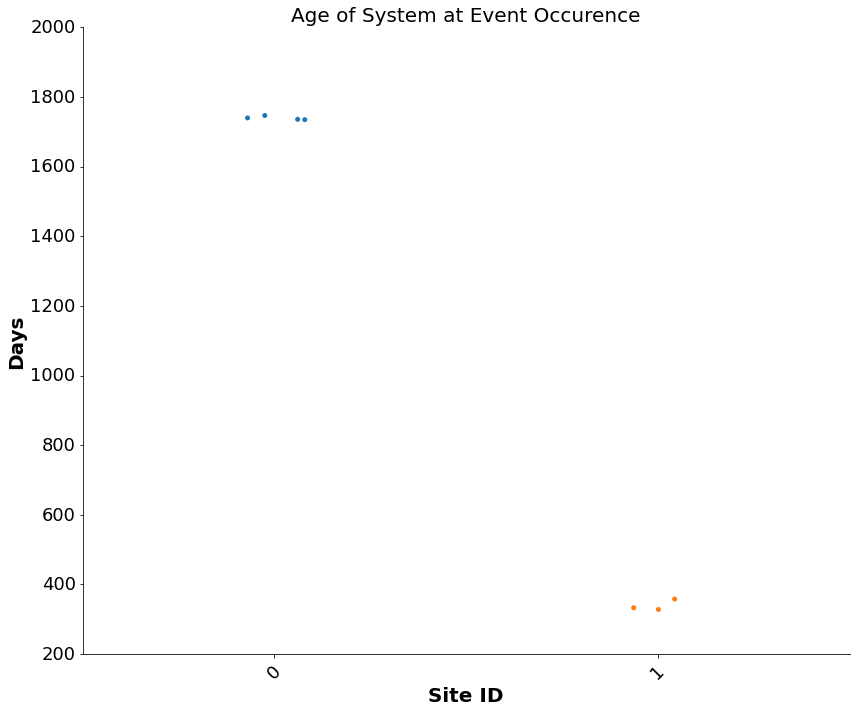

In [41]:
cat_varx = om_col_dict['siteid']
cat_vary= om_col_dict['agedatestart']
sv_nm = 'system_age.png'
myfig = visualize.visualize_categorical_scatter(om_data_update, om_col_dict, cat_varx, cat_vary, fig_sets)

Creating scatter-plot of each event-duration, per site

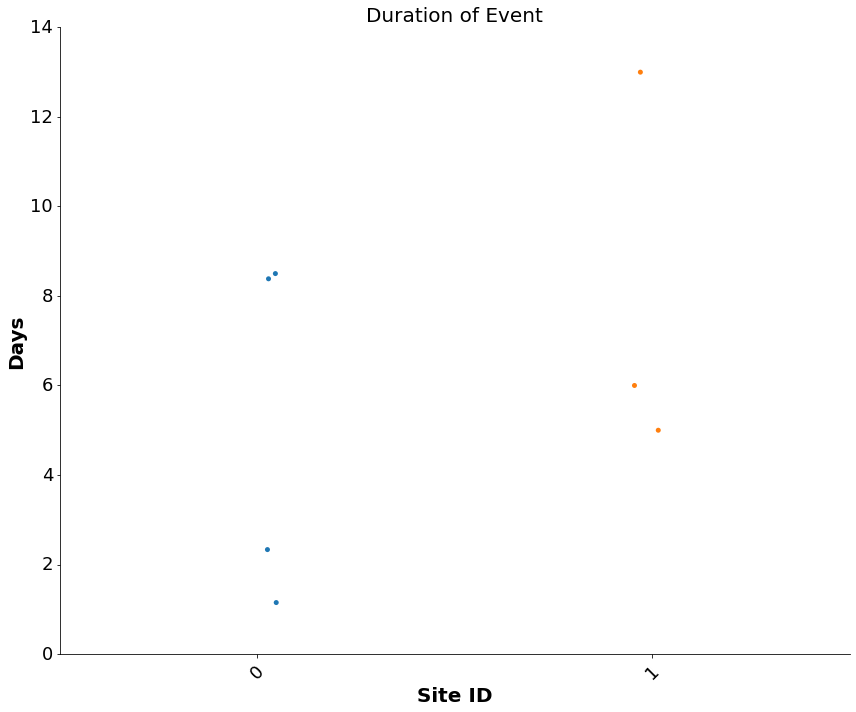

In [42]:
cat_varx = om_col_dict['siteid']
cat_vary= om_col_dict['eventdur']
sv_nm = 'event_dur.png'
myfig = visualize.visualize_categorical_scatter(om_data_update, om_col_dict, cat_varx, cat_vary, fig_sets)

Count-plot of # of events, per site

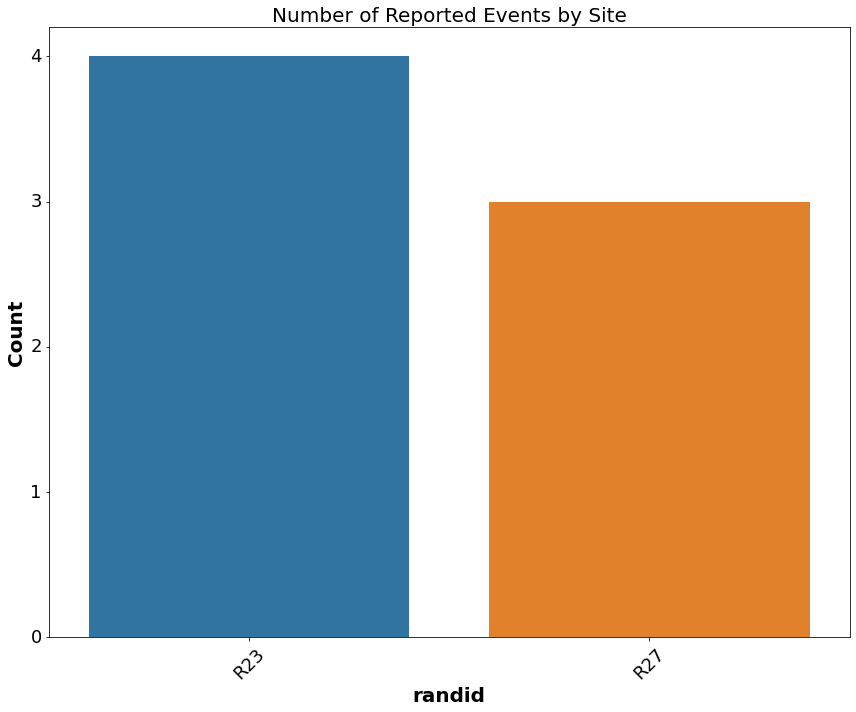

In [43]:
count_var = om_col_dict['siteid']
sv_nm = 'event_count_per_site.png'
myfig = visualize.visualize_counts(om_data_update, om_col_dict, count_var, fig_sets)

Count-plot of # of events, per month

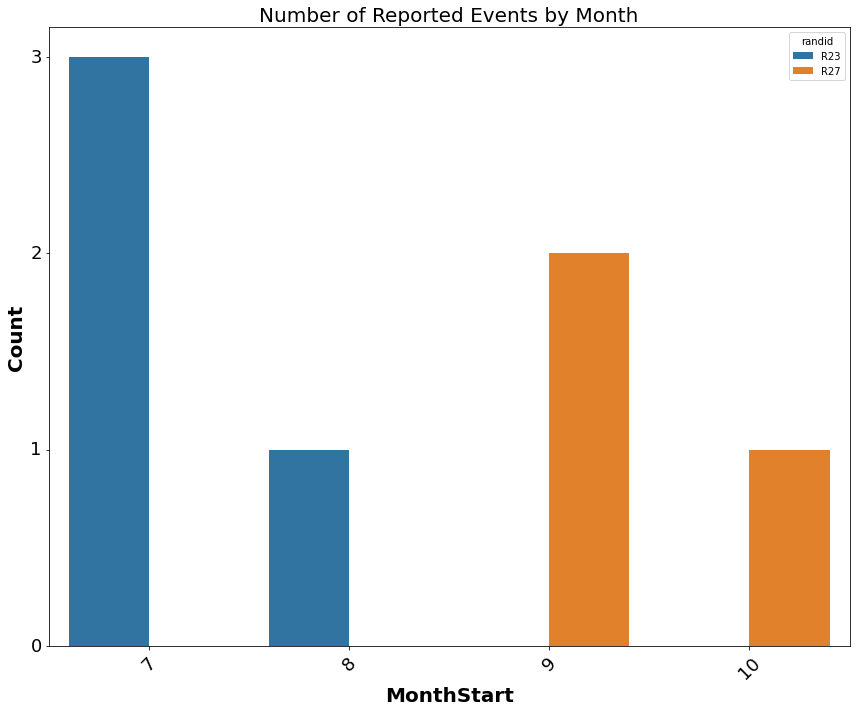

In [44]:
count_var = om_col_dict['modatestart']
sv_nm = 'event_count_per_month.png'
myfig = visualize.visualize_counts(om_data_update, om_col_dict, count_var, fig_sets)